## Training to velocities, 1st derivatives and laplacians

In [1]:
#imports
import jax
import jax.numpy as jnp

import jax_cfd.base as cfd
from jax_cfd.ml import towers
import jax_cfd.ml.train_utils as train_utils
from jax_cfd.base import finite_differences as fd
from jax_cfd.base import grids

import haiku as hk
import numpy as np
import xarray
import random

import pickle
# from jax_cfd.ml.diego_model_utils import SaveObject, forward_pass_module
from jax_cfd.ml.diego_preprocessing import *
# from jax_cfd.ml.diego_train_functions import *
from jax_cfd.ml import nonlinearities
from jax_cfd.ml.diego_cnn_bcs import *

from jax_cfd.ml.newSaveObject import *
from jax_cfd.ml.diego_towers import *

import matplotlib.pyplot as plt
import seaborn

import time

In [2]:
# import data (fine grid)
# create X_data via mean pooling
# create Y_data by calculating everything for each frame and stacking them along the channel dimension

In [99]:
# import data
file_name = '256x64_150_seconds_inner_1'
data = xarray.open_dataset(f'../../creating_dataset/datasets/'+ file_name +'.nc', chunks={'time': '100MB'})

In [124]:
# split by timestamps
x_shape = len(data.x)
y_shape = len(data.y)
high_def = []
for i in range(int(len(data.time))):
    this_time = np.dstack([
        jnp.array([data.u.isel(time = i)]).reshape(x_shape,y_shape).T,
        jnp.array([data.v.isel(time = i)]).reshape(x_shape,y_shape).T
    ])
    high_def.append(this_time)

In [125]:
#warm up time (may want to discard initial stages of simulation since not really representative of turbulent flow?)
dt = float(data.time[0].values)

outer_steps = len(data.time.values)

inner_steps = (data.time[1].values-data.time[0].values)/dt

total_sim_time = outer_steps*inner_steps*dt
print("dt: \t\t" + str(dt))
print("outer_steps: \t" + str(outer_steps))
print("inner_steps: \t" + str(inner_steps))
print("total_sim_time: " + str(total_sim_time))

warm_up = 15 #seconds
warm_index = int(warm_up/total_sim_time * outer_steps // 1)
print("removed points: " + str(warm_index))
high_def = high_def[warm_index:]

print("\n")
step = 100
high_def = high_def[0::step]
print("step = " + str(step))
print("Training dataset shape: ") # (frames, x, y, input channels)
print("\t" + str(np.shape(high_def)))

dt: 		0.015625
outer_steps: 	9600
inner_steps: 	1.0
total_sim_time: 150.0
removed points: 960


step = 100
Training dataset shape: 
	(87, 64, 256, 2)


In [126]:
%time high_def_norm,ogMean,ogStdDev = normalisingDataset(high_def)

CPU times: user 7.87 ms, sys: 3.01 ms, total: 10.9 ms
Wall time: 10.9 ms


## Defining what we are training towards

In [127]:
which_outputs = {
        "u" : False,
        "du" : False,
        "lapu" : True,
        
        "v" : False,
        "dv" : False,
        "lapv" : True
    }

conditions = [
#             [0,0],#u
#             [0,0],#dudx
#             [0,0],#dudy
            [0,0],#lapu

#             [0,0],#v
#             [0,0],#dvdx
#             [0,0],#dvdy
            [0,0]#lapv
        ]

In [128]:
#split into train and test

split = 0.8
split = int(len(high_def)*split//1)
random.shuffle(high_def)

factor = 4

print("Create X dataset: ")
%time X_dataset = creatingDataset(high_def_norm,mean_pooling,factor)

print("\nCreate Y dataset: ")
%time Y_dataset = createDatasetDerivatives(high_def_norm,sampling,factor,which_outputs)

# %time Y_dataset = calculateResiduals(X_dataset,Y_dataset)


X_train = X_dataset[:split]
Y_train = Y_dataset[:split]

X_test = X_dataset[split:]
Y_test = Y_dataset[split:]

# NOTE: padding conditions can be specified via the "conditions" input to the padYDataset function below
# the padXDataset only pads u and v for channel flow conditions, so hard coded for impermeability and no-slip conditions (0,0)
print("\nPadding all datasets: ")
padding = [1,1] #this is for a 3 by 3 kernel, find a better way to define this (so not redifined when creating CNN)
%time X_train = padXDataset(X_train,padding)
%time Y_train = padYDataset(Y_train,padding,conditions)

%time X_test = padXDataset(X_test,padding)
%time Y_test = padYDataset(Y_test,padding,conditions)

print("\nShapes of all datasets")
printAllShapes(X_train,Y_train, X_test,Y_test)

Create X dataset: 
CPU times: user 1.98 s, sys: 2.31 ms, total: 1.98 s
Wall time: 1.99 s

Create Y dataset: 
CPU times: user 142 ms, sys: 1.97 ms, total: 144 ms
Wall time: 145 ms

Padding all datasets: 
CPU times: user 1.36 s, sys: 3.65 ms, total: 1.37 s
Wall time: 1.37 s
CPU times: user 1.38 s, sys: 0 ns, total: 1.38 s
Wall time: 1.38 s
CPU times: user 361 ms, sys: 210 µs, total: 361 ms
Wall time: 362 ms
CPU times: user 360 ms, sys: 569 µs, total: 361 ms
Wall time: 362 ms

Shapes of all datasets
(69, 18, 66, 2)
(69, 18, 66, 2)
(18, 18, 66, 2)
(18, 18, 66, 2)


In [198]:
import numpy as np
import jax.numpy as jnp

import jax
from jax import value_and_grad

import jax_cfd.base as cfd
from jax_cfd.base import grids

import time

def printAllShapes(*things):
    for thing in things:
        print(np.shape(thing))

def staggeredLearningRate(*args):
    """
    accepts tuples with the following info:
    (number of epochs, learning rate)

    example usage: 
    learning_rates = staggeredLearningRate((50,0.005),(50,0.001))
    """
    learning_rates = []
    for arg in args:
        for i in range(arg[0]):
            learning_rates.append(arg[1])
    return learning_rates



        
class MyTraining():
    def __init__(self,X_train,Y_train,X_test,Y_test,rng_key,input_channels,epochs,learning_rates,batch_size = 32,validateEvery=1,printEvery=5,params=None,forward_pass=None,tol = 1e-5):
        self.X_train = X_train
        self.Y_train = Y_train
        self.X_test = X_test
        self.Y_test = Y_test
        self.rng_key = rng_key
        self.input_channels = input_channels
        self.epochs = epochs
        
        if batch_size == None:
            batch_size = len(X_train)
        else:
            self.batch_size = batch_size
        self.validateEvery = validateEvery
       
        self.printEvery = printEvery
        self.params = params
        self.forward_pass = forward_pass
        self.tol = tol
        
        self.losses = []
        self.val_losses = []
        
        self.learning_rates = learning_rates
        self.learning_rate = self.learning_rates[0]
    
    
    # Loss functions
    def MeanSquaredErrorLoss(self, params,input_data, actual):
        preds,truth = self.computePredAndTruth(params,input_data,actual)
        
        return jnp.power(jnp.array(truth) - jnp.array(preds), 2).mean()
    # MeanSquaredErrorLoss = jax.jit(MeanSquaredErrorLoss)


#     def MeanSquaredErrorLossWithDivergence(self,params, input_data, actual):
#         preds,truth = self.computePredAndTruth(input_data,actual)
#         mse = jnp.power(jnp.array(truth) - jnp.array(preds), 2).mean()
#         div = divergence(v0)
#         h = 1
#         return mse + h * div

    def absErrorLoss(self,input_data,actual):
        preds,truth = computePredAndTruth(input_data,actual)
        return ((jnp.array(truth) - jnp.array(preds))).mean()

    #reference:
    # https://goodboychan.github.io/python/deep_learning/vision/tensorflow-keras/2020/10/13/01-Super-Resolution-CNN.html#Build-SR-CNN-Model
    def mse(self,target, ref):
        target_data = target.astype(np.float32)
        ref_data = ref.astype(np.float32)
        err = np.sum((target_data - ref_data) ** 2)

        err /= float(target_data.shape[0] * target_data.shape[1])
        return err

    def my_mse(self,pred,actual):
        err = (jnp.array(pred)-jnp.array(actual))**2
        return err.mean()

    def percentageError(self,approx, truth):
        return (approx-truth)/truth

    def absPercentageError(self,approx,truth):
        return abs(percentageError(approx,truth))

    def mape(self,approx, truth):
        return jnp.mean(abs(percentageError(approx,truth)))





    # Training functions



    def computePredAndTruth(self,params,input_data,actual):
        preds = []
        truth = []
        for i in range(len(input_data)):
            preds.append(self.forward_pass.apply(params, input_data[i]))
            truth.append(actual[i])

        return preds,truth
    
    


    def train_step(self):
        loss, param_grads = value_and_grad(self.MeanSquaredErrorLoss)(self.params,self.X_train, self.Y_train)
        val_loss = self.MeanSquaredErrorLoss(self.params,self.X_test,self.Y_test)
        
#         return jax.tree_map(self.UpdateWeights, param_grads), loss, val_loss
        return jax.tree_map(lambda p,g: p-self.learning_rate*g, self.params, param_grads), loss, val_loss

    def train_stepNoValidation(self,X_train_batch,Y_train_batch):
            loss, param_grads = value_and_grad(self.MeanSquaredErrorLoss)(self.params,self.X_train, self.Y_train)


            return jax.tree_map(self.UpdateWeights,self.params,param_grads), loss
#             return jax.tree_map(lambda p,g: p-self.learning_rate*g, self.params, param_grads), loss

    def eval_validation(self):
        return self.MeanSquaredErrorLoss(self.params,self.X_test,self.Y_test)

    def UpdateWeights(self,params,gradients):
        return params - self.learning_rate * gradients

    

    
    def train(self):
        """
        Input parameter 'params' allows us to keep training a network that has already undergone some 
        training, without having to retrain from scratch
        """

        shapes = np.shape(self.X_train)
        if self.input_channels != shapes[3]:
            print(self.input_channels,shapes[3])
            raise(AssertionError("Non-compatible input shape and input channels"))

        sample_x = jax.random.uniform(self.rng_key, (shapes[1],shapes[2],self.input_channels))

        batch_size = 1
        if self.params == None:
            self.params = self.forward_pass.init(self.rng_key, sample_x)


        print("Shapes of all datasets")
        printAllShapes(self.X_train,self.Y_train,self.X_test,self.Y_test)
        print("\n")


        
        start_time = time.time()
        start_time_local = time.localtime(start_time)
        print("\nStart time: {:d}:{:02d}:{:02d}".format(start_time_local.tm_hour, start_time_local.tm_min, start_time_local.tm_sec))
        
        num_batches = len(self.X_train)//self.batch_size+1
        
        
        for i in range(1, self.epochs+1):
            if i%self.printEvery == 0 or i == 1: #every n epochs
                print("Epoch {:.0f}/{:.0f}".format(i,self.epochs))

            #will fail if learning rates list is not long enough, in which case it keeps using value from last loop
            self.learning_rate = self.learning_rates[i-1]     


            #TODO: using test as validation, change this!
            for batch in range(num_batches):
                if batch != num_batches-1:
                    start, end = int(batch*self.batch_size), int(batch*self.batch_size+self.batch_size)
                else:
                    start, end = int(batch*self.batch_size), None
                
                X_batch, Y_batch = self.X_train[start:end], self.Y_train[start:end]
                
                self.params,loss = self.train_stepNoValidation(X_batch,Y_batch)
                self.losses.append(loss)
            
            if i%self.validateEvery == 0 or i == 1:
                val_loss = self.eval_validation()
                self.val_losses.append(val_loss)


            if i%self.printEvery == 0 or i == 1: #every n epochs
                
                print("\tmse : {:.6f}\t".format(self.losses[-1]), end='')
                if len(self.val_losses) > 0:
                    print("\tval mse : {:.6f}".format(self.val_losses[-1]), end='')
                time_now = time.time()
                time_taken = time_now - start_time
                time_per_epoch = time_taken/(i+1)
                epochs_remaining = self.epochs+1-(i+1)
                time_remaining = epochs_remaining*time_per_epoch
                end_time = time.localtime(time_now + time_remaining)
                print("\tEstimated end time: {:d}:{:02d}:{:02d}".format(end_time.tm_hour, end_time.tm_min, end_time.tm_sec))
                print("\n")
            
            

            if i != 1:
                if abs(self.losses[-2]-self.losses[-1])<self.tol:
                    print("\nConvergence reached at epoch {:.0f}".format(i))
                    print("\tmse : {:.6f}\t".format(self.losses[-1]), end='')
                    if self.val_loss[-1] is not None:
                        print("\tval mse : {:.6f}".format(self.val_loss[-1]), end='')
                    print("\n")
                    break

        if i == self.epochs:
            print("\nFinished training at max epochs\n")

    
        



def reshapeData(mydata,mygrid,
                offsets=[(1.0,0.5),
                         (0,5,1.0)],
                bcs = [cfd.boundaries.channel_flow_boundary_conditions(ndim=2),
                      cfd.boundaries.channel_flow_boundary_conditions(ndim=2)]):
    """defaults to channel flow settings"""
    return (grids.GridVariable(array = grids.GridArray(data = mydata[:,:,0],offset=offsets[0],grid=mygrid),bc=bcs[0]),
          grids.GridVariable(array = grids.GridArray(data = mydata[:,:,1],offset=offsets[1],grid=mygrid),bc=bcs[1]))

## Defining model shape

In [199]:
def ConvNet(x):
    cnn = CNN(CNN_specs)
    return cnn(x)

CNN_specs = {
    "hidden_channels" : 16,
    "hidden_layers" : 3,
    "nonlinearity" : "relu",
    "num_output_channels" : 2
}
input_channels = 2

# CNN_specs = None

In [200]:
forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

In [201]:
instance = MyTraining(X_train,Y_train,X_test,Y_test,
                      jax.random.PRNGKey(42), #rng_key
                      input_channels=2,
                      epochs = 2,
                      printEvery=1,#epochs
                      learning_rates=staggeredLearningRate((120,0.01),(70,0.001)),
                      batch_size = 32,
                      validateEvery=1,
                      params=None,
                      forward_pass=forward_pass,
                      tol = 1e-10)

%time instance.train()

Shapes of all datasets
(69, 18, 66, 2)
(69, 18, 66, 2)
(18, 18, 66, 2)
(18, 18, 66, 2)



Start time: 2:45:27
Epoch 1/2


TypeError: unsupported operand type(s) for -: 'dict' and 'DeviceArray'

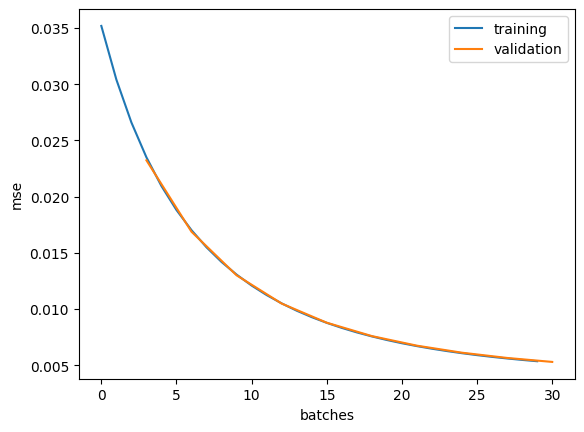

In [90]:

batches = np.arange(len(instance.losses))
val_step = len(instance.losses)//len(instance.val_losses)

batches_val = batches[::val_step]+val_step
plt.plot(batches+1,instance.losses, label="training")
plt.plot(batches_val,instance.val_losses,label="validation")
plt.ylabel("mse")
plt.xlabel("batches")
# plt.yscale("log")
plt.legend()

In [13]:
description = ""

In [14]:
toSave = newSaveObject(instance.params,instance.losses,instance.val_losses,description,CNN_specs)

In [28]:
save_path = "./../models/correctors/laplacian_correctors/first_laplacians.pickle"

In [16]:
with open(save_path,"wb") as f:
    pickle.dump(toSave,f)

## Loading model

In [29]:
with open(save_path,'rb',) as pickle_file:
    loaded = pickle.load(pickle_file)
    CNN_specs = loaded.CNN_specs
    loaded.forward_pass = hk.without_apply_rng(hk.transform(ConvNet))

In [30]:
loaded.description

'57 min CPU time, learning_rates = ((120,0.01),(30,0.001)), 150 epochs'

## Evaluating the model 

In [31]:
# loss_eval = mse
def loss_eval(in1,in2):
    return abs(in1-in2)

In [32]:
# Make predictions for every slice in X_test
predictions = []
for mySlice in X_test:
    predictions.append(loaded.forward_pass.apply(loaded.params,mySlice))

In [33]:
# Compute error predictions vs Y_test
errors = []
for j in range(len(predictions)):
    partial = []
    partial.append(loss_eval(predictions[j],Y_test[j]))
#     partial.append(mape(predictions[j],Y_test[j]))
    errors.append(partial)

In [34]:
# Compute what would have been obtained from input without the CNN (to see if there is an improvement)

In [35]:
# calculate laplacians for input
inputLaps = []
for j in range(len(X_test)):
    inputLaps.append(npLaplacian(X_test[j]))

In [36]:
# Compute error computed laps for input vs true laps
errorsLaps = []
for j in range(len(predictions)):
    partial = []
    partial.append(loss_eval(inputLaps[j],Y_test[j]))
#     partial.append(mape(predictions[j],Y_test[j]))
    errorsLaps.append(partial)

In [37]:
print("Test error for NN")
print("\tError : {:.6f}".format(np.mean(errors)))
print("\tError/mean(||truth||) : {:.6f}".format(np.mean(errors) / np.mean(np.abs(Y_test))))

print("\nError if no NN used")
print("\tError : {:.6f}".format(np.mean(errorsLaps)))
print("\tError/mean(||truth||) : {:.6f}".format(np.mean(errorsLaps) / np.mean(np.abs(Y_test))))

Test error for NN
	Error : 0.042474
	Error/mean(||truth||) : 1.699393

Error if no NN used
	Error : 0.242677
	Error/mean(||truth||) : 9.709582
